In [14]:
%cd vanhateren_iml

[Errno 2] No such file or directory: 'vanhateren_iml'
/Users/peterbaumbacher/Dropbox/Cal/2018 - Fall/vs265/proj/ICA_Comparison/vanhateren_iml


In [11]:
import numpy as np
import array 
import sklearn
import scipy as sp
from skimage import color
from sklearn.feature_extraction import image
from sklearn.decomposition import FastICA, PCA
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

patch_size  = 16
p_per_image = 200
n_images    = 300
r_dim       = 64

In [3]:
def load_patches(n_images, p_per_img, patch_size):

    fmt_string = 'imk{0:05d}.iml'
    max_img_num = 4000
    
    patches = []
    for _ in range(n_images):
        while True:
            try:
                img_num = np.random.randint(1, max_img_num)
                filename = fmt_string.format(img_num)
                with open(filename, 'rb') as handle:
                    s = handle.read()
                    break
            except:
                continue
        arr = array.array('H', s)
        arr.byteswap()
        img = np.array(arr, dtype='uint16').reshape(1024 * 1536)
        img = (img - np.mean(img)) / np.std(img)
        img = img.reshape(1024, 1536)
        
        patch = image.extract_patches_2d(img, [patch_size, patch_size], max_patches = p_per_image)
        patches.append(patch)
        
    patches = np.array(patches)
    patches = np.reshape(patches, [n_images*p_per_image, patch_size * patch_size])
    return patches

In [16]:
def plotDataTiled(data, title="", prevFig=None):
  """
    Create a matplotlib plot that displays data as subplots
    Inputs:
      data [np.ndarray] 2-D array of dims (numPixels, batchSize)
        It is assumed that numPixels has an even square root
      title [str] optional string to set as the figure title
  """
  if len(data.shape) == 2:
    (numPixels, batchSize) = data.shape
  elif len(data.shape) == 1:
    numPixels = data.shape
    batchSize = 1
    data = data[:,None]
  else:
    assert 0, ("len(data.shape) should = 2 or 1")
  assert numPixels%np.sqrt(numPixels) == 0, (
        "data.shape[0]  must have an even square root")
  pixelEdgeSize = int(np.sqrt(numPixels))
  subplotEdgeSize = int(np.ceil(np.sqrt(batchSize)))
  if prevFig is not None:
    (fig, subAxes, axisImage) = prevFig
  else:
    fig, subAxes = plt.subplots(nrows=subplotEdgeSize, ncols=subplotEdgeSize)
    axisImage = [None]*len(fig.axes)
  for axisIndex, axis in enumerate(fig.axes):
    if axisIndex < batchSize:
      image = data[:,axisIndex].reshape(pixelEdgeSize, pixelEdgeSize)
      if prevFig is not None:
        axisImage[axisIndex].set_data(image)
      else:
        axisImage[axisIndex] = axis.imshow(image, cmap="Greys",
          interpolation="nearest")
        axis.tick_params(
          axis="both",
          bottom="off",
          top="off",
          left="off",
          right="off")
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    else:
      for spine in axis.spines.values():
        spine.set_visible(False)
      axis.tick_params(
        axis="both",
        bottom="off",
        top="off",
        left="off",
        right="off")
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
  fig.suptitle(title)
  if prevFig is not None:
    fig.canvas.draw()
  else:
    fig.show()
  return (fig, subAxes, axisImage)

def plotImg(img):
    # img = (img - img.min()) / abs(img.max() - img.min())
    plt.figure()
    plt.imshow(img, vmin=img.min(), vmax=img.max(), cmap='gray')

In [6]:
patches = load_patches(n_images, p_per_image, patch_size)
patches = patches - patches.mean(axis=0)

# reshape for PCA/ICA 
patches = np.reshape(patches, [n_images*p_per_image, patch_size * patch_size])
pca = PCA(n_components=r_dim, whiten=True)
data_wht = pca.fit_transform(patches)

#cov      = np.divide(patches.T@patches, n_images*p_per_image)
#u, s, v  = np.linalg.svd(cov)
#isqrtS   = np.diag(1 / np.sqrt(s+1e-6)) 
#w_filter = np.dot(u, np.dot(isqrtS, u.T))
#data_wht = np.dot(patches, w_filter)


/Users/peterbaumbacher/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(<matplotlib.figure.Figure at 0x10e8b0128>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10526acc0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x13c45b4e0>]], dtype=object),
  <matplotlib.image.AxesImage at 0x13c59e198>])

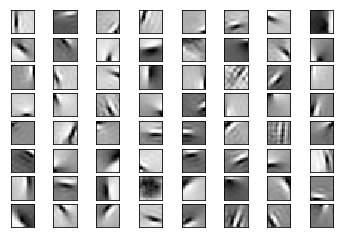

In [7]:
# Use Fast ICA to find independent components of image patches
ica = FastICA(n_components = r_dim, max_iter=500)
ica.fit_transform(data_wht)
W   = ica.components_

W_vis = W @ np.real( np.linalg.inv(sp.linalg.sqrtm(W.T @ W)) )

W_vis = pca.inverse_transform(W)

plotDataTiled(W_vis.T)

In [8]:
def gen_neighborhood(x_dim, y_dim, n_code = 0):
    NB = np.zeros([x_dim*y_dim, x_dim*y_dim])
    n  = x_dim * y_dim
    for i in range(n):
        for j in range(n):
            if n_code == 0:
                # direct connections omly 
                if np.abs(i%x_dim - j%x_dim) < 2 and np.abs(i//x_dim - j//x_dim) < 2:
                    NB[i,j] = 1
                    
            else:
                # direct connection 
                if np.abs(i%x_dim - j%x_dim) < 2 and np.abs(i//x_dim - j//x_dim) < 2:
                    NB[i,j] = 1
                # loop connection in x
                elif np.abs(i%x_dim - j%x_dim - x_dim) < 2 and np.abs(i//x_dim - j//x_dim) < 2:
                    NB[i,j] = 1
                elif np.abs(i%x_dim - j%x_dim + x_dim) < 2 and np.abs(i//x_dim - j//x_dim) < 2:
                    NB[i,j] = 1
                # loop connection in y 
                elif np.abs(i%x_dim - j%x_dim) < 2 and np.abs(i//x_dim - j//x_dim - y_dim) < 2:
                    NB[i,j] = 1
                elif np.abs(i%x_dim - j%x_dim) < 2 and np.abs(i//x_dim - j//x_dim + y_dim) < 2:
                    NB[i,j] = 1
                # loop connection in x and y
                elif np.abs(i%x_dim - j%x_dim - x_dim) < 2 and np.abs(i//x_dim - j//x_dim - y_dim) < 2:
                    NB[i,j] = 1
                elif np.abs(i%x_dim - j%x_dim + x_dim) < 2 and np.abs(i//x_dim - j//x_dim + y_dim) < 2:
                    NB[i,j] = 1
                # no connection
                else:
                    continue

            
                
    NBNZ = []    
    for k in range(n):
        NBNZ.append(np.nonzero(NB[k]))
    return NB , NBNZ



def TICA_Gradient(B, X, NB, NBNZ):
    eps = .005
    n   = np.shape(B)[1]
    N   = np.shape(X)[1]
    U   = B.T @ X
    Usq = U ** 2
    
    
    # calculate local energies
    E = []
    
    for i in range(n):
        temp = np.take(Usq, NBNZ[i][0], axis = 0)
        E.append(np.sum(temp, axis = 0))
        
    E = np.array(E)
    # take nonlinearity
    g = []
    for i in range(n):
        g_i = -(eps + E[i])**-0.5
        g.append(g_i)
    g = np.array(g)
        
    # Calculate convolution with neighborhood
    F = []
    for i in range(n):
        temp = np.take(g, NBNZ[i][0], axis = 0)
        F.append(np.sum(temp, axis = 0))
    F = np.array(F)
    #F = np.expand_dims(F, 1)

    
    dB = X @ (U * F).T / N
    
    objective = np.mean(np.sqrt((eps + E)))
    
    return dB, objective
    

            
            
            

step size is now: 0.2
iteration: 0
objective: 2.1085234098
step size is now: 0.4
iteration: 50
objective: 2.03463101031
iteration: 100
objective: 2.02923274955
iteration: 150
objective: 2.02749758047
iteration: 200
objective: 2.02548590916
iteration: 250
objective: 2.02451264562
iteration: 300
objective: 2.0243446967
iteration: 350
objective: 2.02424832042
iteration: 400
objective: 2.02400223324
iteration: 450
objective: 2.02403965287


/Users/peterbaumbacher/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(<matplotlib.figure.Figure at 0x13c60f710>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c622d30>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x111d2dc88>]], dtype=object),
  <matplotlib.image.AxesImage at 0x111e69940>])

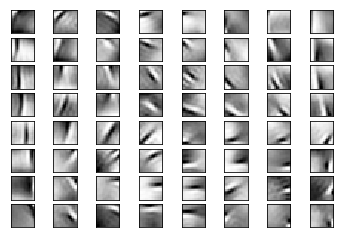

In [9]:
# TICA Loop

patches = load_patches(n_images, p_per_image, patch_size)
# patches = patches - patches.mean(axis=0)

# reshape for PCA/ICA 
patches  = np.reshape(patches, [n_images*p_per_image, patch_size * patch_size])
pca      = PCA(n_components=r_dim, whiten=True)
data_wht = pca.fit_transform(patches)

# set parameters
x_dim = 8
y_dim = 8
n     = x_dim * y_dim
n_t   = 500  # number of wieght updates
step  = 0.1  # initial step size

# Initialize components
X = data_wht.T  # algotithm assumes data as column vectors
N = X.shape[1]  # number of data points (patches)
B = np.random.randn(X.shape[0], n)

# generate neighborhood
NB, NBNZ = gen_neighborhood(x_dim, y_dim, n_code = 1)

# orthogonalize B 
B = B @ np.linalg.inv(sp.linalg.sqrtm(B.T @ B))

# main loop
for i in range(n_t):
    if i % 50 == 1:
        print('iteration: ' + str(i - 1))
        print('objective: ' + str(objective))
    # update
    dB, objective = TICA_Gradient(B, X, NB, NBNZ)
    if i % 5 == 0:
        _ , obj1 = TICA_Gradient(B + dB * step * 0.5, X, NB, NBNZ)
        _ , obj2 = TICA_Gradient(B + dB * step * 1.0, X, NB, NBNZ)
        _ , obj3 = TICA_Gradient(B + dB * step * 2.0, X, NB, NBNZ)
        
        if obj1 < obj2 and obj1 < obj3: 
            step = step * 0.5
            print('step size is now: ' + str(step))
        elif obj3 < obj1 and obj3 < obj2: 
            step = step * 2.0 
            print('step size is now: ' + str(step))
        else: 
            continue
        
        
    B += dB * step
    # reorthogonalize
    B = B @ np.linalg.inv(sp.linalg.sqrtm(B.T @ B))
    
    
# reorthogonalize
B = B @ np.real(np.linalg.inv(sp.linalg.sqrtm(B.T @ B)))


A = pca.inverse_transform(B.T)

plotDataTiled(A.T)


            

In [12]:
# Find sparsity parameters
transformed_patches = data_wht @ B.T

Bs = []
As = []
for i in range(r_dim):
    kde = KernelDensity()
    activations = transformed_patches[:,i].reshape((-1, 1))
    #print(activations.shape)
    E_abs = np.mean(np.abs(activations))
    E_square = np.mean(activations ** 2)
    kde.fit(activations)
    p_s_zero = np.exp(kde.score(np.array([0]).reshape(1,1)))
    
    b = (2 * p_s_zero * E_square - E_abs) / (E_square - E_abs**2)
    b = np.clip(b, 0, np.sqrt(2/E_square))
    a = (1 - E_abs * b) / E_square
    a = np.clip(a, 0, 1/E_square)
    
    Bs.append(b)
    As.append(a)
Bs = np.array(Bs)
As = np.array(As)
print(Bs)
print(As)

[ 0.11610587  0.12159286  0.12549349  0.12312862  0.09272908  0.03473621
  0.13974845  0.07107122  0.14663871  0.13912329  0.08968445  0.10638823
  0.11267169  0.09326472  0.10752168  0.12787747  0.09532808  0.09167429
  0.13502605  0.14474742  0.14460028  0.13262397  0.15031045  0.11762554
  0.12690534  0.13339897  0.13230055  0.12459258  0.14007894  0.13967995
  0.11554683  0.09687373  0.13711774  0.12626164  0.1232559   0.12691527
  0.12521203  0.1109175   0.05573304  0.11402893  0.13291546  0.13873514
  0.11809361  0.11727703  0.05123189  0.13797462  0.13049081  0.12380691
  0.09153954  0.09848414  0.12212757  0.10195633  0.12304432  0.12252955
  0.09343234  0.10192073  0.12401937  0.12879896  0.14068404  0.0946362
  0.09152884  0.12631373  0.13231252  0.12436058]
[ 0.93272658  0.93016137  0.92850252  0.9293148   0.9450309   0.97839857
  0.92155186  0.95711308  0.9182107   0.92177719  0.94683669  0.93775039
  0.93484653  0.94484801  0.9372894   0.92726555  0.9437427   0.94582147
  

In [13]:
def denoise_img(img, pca, W_ortho, nonlinearity):
    """
    Denoises an img using ica. Assumes that img has already been 0-meaned, etc.
    """
    img_r, img_c = img.shape
    img_patches = image.extract_patches_2d(img, (patch_size, patch_size))
    patch_count = img_patches.shape[0]
    img_patches = img_patches.reshape(patch_count, patch_size**2)
    #print(img_patches[3])
    
    # pca = PCA(n_components=r_dim, whiten=True)
    whitened_patches = pca.transform(img_patches)
    #print(whitened_patches[3])
    components = whitened_patches @ W_ortho.T
    print(components[3])
    #shrunk_components = nonlinearity(components)
    shrunk_components = np.apply_along_axis(nonlinearity, 1, components)
    print(shrunk_components[3])
    denoised_patches = pca.inverse_transform(shrunk_components @ np.linalg.inv(W_ortho.T))
    #print(denoised_patches[3])
    
    # Reconstruct the image:
    denoised_patches = denoised_patches.reshape(patch_count, patch_size, patch_size)
    return image.reconstruct_from_patches_2d(denoised_patches, (img_r, img_c))

MSE: 0.089571533371
[-0.28373345 -0.9517389  -0.07909636  0.16524416 -0.09098682 -0.45613418
 -0.02139754 -0.19519083  0.06244035 -0.22803067  0.05005369 -0.5745636
  0.67240888 -0.1673093  -0.65266557 -0.0212679  -0.9879448  -0.14550035
  1.35356025  0.71490764  0.54002048 -0.42916749  1.15174581  0.59808883
  0.16450648  0.33530837  1.00243151 -0.17768313 -0.49179433  0.59676288
  1.09186689  0.34551253  0.18990903 -0.27882011  0.18488746 -0.09249791
 -0.11395914 -1.02944872  0.50305086 -0.55623158 -0.23134032  0.76305284
 -1.05829189 -0.68262782  0.85625642 -0.1865356   0.78777242  0.01176726
  0.08473936 -0.39290039 -0.25961038 -0.96824198 -0.02931738 -0.62638368
 -0.06796558  1.2953374   0.5458148   0.19924616  0.24078556 -0.80983872
  0.43378037 -0.65358295 -0.15232188  0.05130504]
[-0.1944821  -0.71557967 -0.0324182   0.10033323 -0.04921514 -0.34457408
 -0.         -0.13508265  0.01446434 -0.14593721  0.0180276  -0.42350464
  0.49873513 -0.1085585  -0.48424559 -0.         -0.747

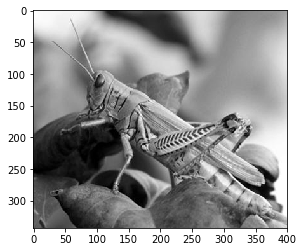

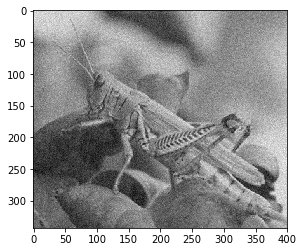

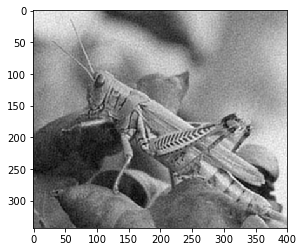

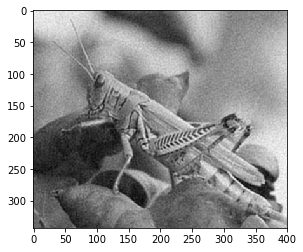

In [18]:
#img = load_img('imk00204.iml')
img = plt.imread("../grasshopper.jpg", format="jpeg")
img = color.rgb2gray(img)
img = (img - np.mean(img)) / np.std(img)
plotImg(img)
# noise_img = np.random.normal(scale=0.8,size=(1024, 1536)) + img
noise_img = np.random.normal(scale=0.3,size=(343, 400)) + img
sigma_squared = 0.3
print("MSE: " + str(np.mean((img-noise_img)**2)))
plotImg(noise_img)
#b_sigma_2 = 0.005
nonlinearity = lambda u : np.sign(u) * np.maximum(0, np.abs(u) - sigma_squared*Bs) / (1 + sigma_squared*As)
d_img = denoise_img(noise_img, pca, B, nonlinearity)
print("MSE: " + str(np.mean((img-d_img)**2)))
plotImg(d_img)
sigma_squared = np.sqrt(sigma_squared)
nonlinearity = lambda u : np.sign(u) * np.maximum(0, np.abs(u) - sigma_squared*Bs) / (1 + sigma_squared*As)
d_img = denoise_img(noise_img, pca, B, nonlinearity)
print("MSE: " + str(np.mean((img-d_img)**2)))
plotImg(d_img)